# *Thermal Transport in a 2D Ti:Sapphire Crystal*

In this demo, we solve the two-dimensional diffusion equation in a rectangular Ti:sapphire crystal, with Dirichlet boundary condition $u_D$
on the sides and initial condition $T_\mathrm{init}$ inside the crystal body.

$$
\begin{align}
  u'   &= \alpha\nabla^2 u        \quad\text{in a short cylinder} \\
  u    &= u_D  \hphantom{Du}\quad\text{on the side boundaries} \\
  u    &= u_0  \hphantom{Du}\quad\;\text{at $t = 0$}
\end{align}
$$
with boundary conditions
$$
\begin{align}
  u_0  &= T_0 + \exp\bigl[ -\tfrac{1}{2}\bigl(\tfrac{x}{\xi}\bigr)^2 \bigr]
                \bigl[ \tfrac{1}{2}(dT_\mathrm{lo} + dT_\mathrm{hi}) + (dT_\mathrm{hi} - dT_\mathrm{lo}) \bigl(\cos^2\bigl(\tfrac{\pi y}{L}\bigr) - \tfrac{1}{2} \bigr) \bigr], \\
  u_D  &= T_0.
\end{align}
$$

## Preamble

Needed imports and definitions:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time as tm
import copy

# import os
# import sys
# import re
# from IPython.display import Image
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
from fenics import *

In [3]:
def minmax(it):
    min = max = None
    for val in it:
        if min is None or val < min:
            min = val
        if max is None or val > max:
            max = val
    return min, max

simulation parameters:

In [4]:
## define main simulation parameters
# -- crystal properties
a_Al2O3 = 5.65e-2    # cm^2/s diffusion constant of sapphire (Al2O3)
a_perp  = 5.58e-2    # perpendicular to C
a_para  = 5.77e-2    # parallel to C
# -- crystal dimensions
width = 10.0         # diameter /cm
leng =   7.60        # length /cm
# -- mesh density
nx = 75              # mesh density along x-axis
ny = 60              # mesh density along y-axis
# -- time step
Ttot =   1.00        # total simulation time
n_steps =  500       # number of time steps
dt = Ttot / n_steps  # size of time step
nip =  25            # number of intervals between plots

# derived parameters
hwd = width / 2

print("duration:  %5.3f" % Ttot)
print("time-step: %5.3f" % dt)
print("plot-step: %5.3f" % (dt * nip))
print("num-plots: %5d" % (n_steps / nip))

duration:  1.000
time-step: 0.002
plot-step: 0.050
num-plots:    20


mesh the domain:

In [5]:
# create mesh and define function space
mesh = RectangleMesh(Point(-hwd, 0), Point(hwd, leng), nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# ranges
xmin, xmax = minmax(mesh.coordinates()[:,0])
ymin, ymax = minmax(mesh.coordinates()[:,1])
print(xmin, xmax)
print(ymin, ymax)

-5.0 5.0
0.0 7.6


set boundary condition and initial value

In [6]:
# define boundary and initial conditions, and sources
T0    = 20.0   # deg C
dT    =  3.80 # deg C
dThi  =  5.000 # deg C
dTlo  =  4.000 # deg C
wdT   =  1.00  # cm
sg_px = 8      # 1
sg_py = 1      # 1

# define Dirichlet boundary condition for sides
tol = 1.e-13
def boundary_D(x, on_boundary):
    return on_boundary and (near(x[0], -hwd, tol) or near(x[0], hwd, tol))
bc = DirichletBC(V, Constant(T0), boundary_D)

# define Neumann input, -∂u/∂n = g
# use small dT, say 0.009, to simulate heat deposition inwards, across the crystal faces
gi = Expression('-dT * exp( - pow(pow(x[0],2) / (2 * pow(wdT,2)), px))',
                degree=1, T0=T0, dT=dT, wdT=wdT, px=sg_px)

# define heat source
# could be used as a steady source, in which case set small values for dTlo and dThi (say, 0.012 and 0.039)
# or simply as an initial condition, in which case set much larger values for dTlo and dThi (say, 12.00 and 4.00)
#
# cos2 x complexSG
hsc = Expression('T0 + ((dThi+dTlo)/2 + (dThi-dTlo)*(pow(cos(pi*x[1]/l), 2*py) - 1/2)) \
                    * exp(-0.5 * pow(x[0] / (w*3/4 + (w/2) * (pow(cos(pi * x[1] / l), 2) - 1/2)), 2*px))',
                 degree=1, T0=T0, dThi=dThi, dTlo=dTlo, w=wdT, l=leng, px=sg_px, py=sg_py)
#
# cos2 x SG
hsg = Expression('T0 + ((dThi+dTlo)/2 + (dThi-dTlo)*(pow(cos(pi*x[1]/l), 2*py) - 1/2)) \
                    * exp(-0.5 * pow(x[0]/w, 2*px))',
                 degree=1, T0=T0, dThi=dThi, dTlo=dTlo, w=wdT, l=leng, px=sg_px, py=sg_py)
#
# exp(decay) x SG
hse = Expression('T0 + dT * (exp(-x[1]/dl) + exp((x[1]-l)/dl)) \
                    * exp(-0.5 * pow(x[0]/w, 2*px))',
                 degree=1, T0=T0, dT=dT, w=wdT, l=leng, dl=0.8*leng, px=sg_px)

# define initial value
# u_n = interpolate(Constant(T0), V)
u_n = interpolate(hse, V)
u_min = u_n(leng/2,hwd)
u_max = u_n(0.,0.)
print(u_min, u_max)

20.0 24.888718228068722


define the variational problem and main simulation function `evolve`:

In [7]:
# define variational problem
u = TrialFunction(V)
v = TestFunction(V)

# source term
f = Constant(0)  # no source term
# f = hs

# F = u*v*dx + dt*a_Al2O3*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx + gi*v*ds  # w/ Neumann BC
F = u*v*dx + dt*a_Al2O3*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx  # w/ heat deposition
a, L = lhs(F), rhs(F)

# define time-evolution function
def evolve():

    # report initial state
    yield u_n

    # time-stepping
    u = Function(V)
    t = 0
    for n in range(1, n_steps + 1):

        # update current time
        t += dt

        # compute solution
        solve(a == L, u, bc)

        # report current state
        if n % nip == 0:
            yield u

        # update previous solution
        u_n.assign(u)

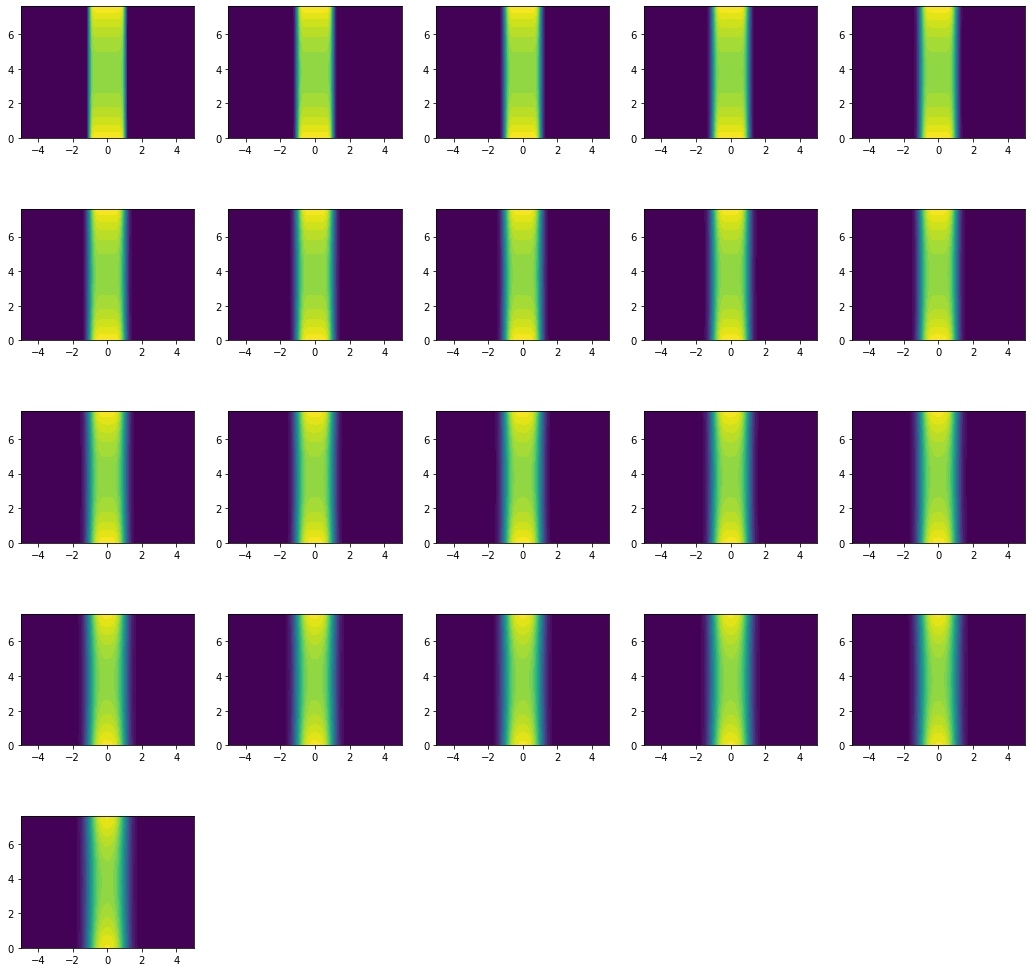

In [8]:
n_rows = 5
n_cols = 5
fig_wd = 18
# default sizing here yields unit aspect ratio
plt.figure(figsize = (fig_wd, fig_wd * n_rows // n_cols))

idx = 0
for u in evolve():
    idx += 1
    plt.subplot(n_rows, n_cols, idx)
    plot(u, vmin=u_min, vmax=u_max)

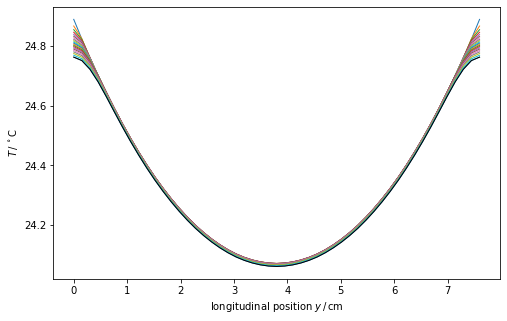

In [15]:
# default sizing here yields unit aspect ratio
plt.figure(figsize = (8,5))

tol = 3.e-5  # avoid hitting points outside the domain
xv = np.linspace(xmin * (1 - tol), xmax * (1 - tol), 51)
yv = np.linspace(ymin * (1 - tol), ymax * (1 - tol), 51)
ptsX = [(x_, leng/30) for x_ in xv]
ptsY = [(0., y_) for y_ in yv]

idx = 0
for u in evolve():
    idx += 1
    uy = np.array([u(pt) for pt in ptsY])
    plt.plot(yv, uy, lw=1)
plt.plot(yv, uy, 'k', lw=1)
plt.xlabel(r'longitudinal position $y\,/\,\mathrm{cm}$')
plt.ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
plt.show()

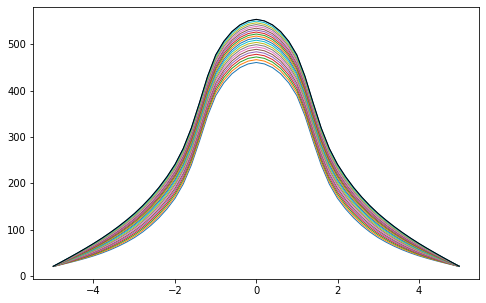

In [10]:
# ranges
xmin, xmax = minmax(mesh.coordinates()[:,0])
ymin, ymax = minmax(mesh.coordinates()[:,1])

# default sizing here yields unit aspect ratio
plt.figure(figsize = (8,5))

tol = 3.e-3  # avoid hitting points outside the domain
xv = np.linspace(xmin * (1 - tol), xmax * (1 - tol), 51)
pts = [(x_, 0) for x_ in xv]

idx = 0
for u in evolve():
    idx += 1
    ux = np.array([u(pt) for pt in pts])
    plt.plot(xv, ux, lw=1)
plt.plot(xv, ux, 'k', lw=1)
plt.show()

In [ ]:
mesh